In [13]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# data import - choose between arrivals or departures
cleaned_df = pd.read_csv('/Users/alexander/Work/Ironhack/Week12/Project/cleaned_arrivals_data.csv')

cleaned_df.sample(10)

# Sum all positive delays
time_delta = cleaned_df[cleaned_df['Time Difference (Minutes)'] > 0].sum()

print(time_delta['Time Difference (Minutes)'])

lost_days = time_delta['Time Difference (Minutes)'] / 60 / 24 #convert to days
print(lost_days)

# check number of days we checked

unique_days = cleaned_df['Date'].nunique()
print(unique_days)

77234
53.63472222222222
20


In [3]:
# the number of flights per airline
flight_counts = cleaned_df['Airline'].value_counts()

# remove airlines with less than 10 flights
filtered_airlines = flight_counts[flight_counts >= 10].index
filtered_df = cleaned_df[cleaned_df['Airline'].isin(filtered_airlines)]

# one hot encoding on the status column
status_dummies = pd.get_dummies(filtered_df['Status'], prefix='Status')
filtered_df = pd.concat([filtered_df, status_dummies], axis=1)

# we only care about delayed because we are treating early and on time as the same

display(filtered_df)

,Departure,Destination,Terminal,Baggage Claim,Gate,Flight Number,Aircraft Type,Plane Reg,Flight Status,Airline,...,Actual Arrival Time,Status,Time Difference (Minutes),Temperature,Wind Speed,Type,Country,Status_Delayed,Status_Early,Status_On-Time
0,Izmir ADB,Berlin,1,A4,N02,XQ 966,737-800 Winglets,TCSUU,Arrived,Sun Express (XQ),...,06:03:00,Early,-27,23.8,10.5,budget,Turkey,False,True,False
1,Beijing,Berlin,1,A3,X17,HU 489,A330-300,B303C,Arrived,Hainan Airlines (HU),...,07:11:00,Delayed,26,23.8,10.5,premium,China,True,False,False
2,New York EWR,Berlin,1,A2,Y17,UA 962,767-400/400ER,N76062,Arrived,United Airlines (UA),...,07:07:00,Early,-8,23.8,10.5,premium,USA,False,True,False
4,Doha,Berlin,1,A4,X07,QR 079,787-9 Dreamliner,A7BHM,Arrived,Qatar Airways (QR),...,07:21:00,Delayed,1,23.8,10.5,premium,Qatar,True,False,False
5,Trieste,Berlin,2,C2,Z34,FR 6781,737 MAX 8,9HVUF,Arrived,Ryanair (FR),...,07:14:00,Early,-21,23.8,10.5,budget,Italy,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4749,Dublin,Berlin,2,C3,Z38,FR 5418,737-800 Winglets,9HQCB,Arrived,Ryanair (FR),...,22:57:00,Early,-3,22.2,11.0,budget,Ireland,False,True,False
4750,Madrid,Berlin,1,A3,A38,I2 3674,A321 neo,ECOAU,Arrived,IBERIA Express (IBS),...,22:47:00,Early,-13,22.2,11.0,budget,Spain,False,True,False
4751,Paris Orly,Berlin,1,B2,N01,TO 3412,737-800 Winglets,FGZHC,Arrived,Transavia France (TO),...,23:09:00,Early,-1,22.2,11.0,budget,France,False,True,False
4752,Palma de Mallorca,Berlin,1,A3,A30,EW 8593,A321-200,DAIDU,Arrived,Eurowings (EW),...,23:51:00,Delayed,26,22.2,11.0,budget,Spain,True,False,False


In [14]:
# ideal sample size
def calculate_sample_size(Z, p, E):
    n = (Z**2 * p * (1 - p)) / E**2
    return math.ceil(n)  # round up to the nearest  number

# params:
Z = 1.96  # Z-score for 95% confidence level
p = 0.5  # Estimated proportion (most conservative estimate)
margins_of_error = [0.01, 0.03, 0.05]  # Different margin of error values

# Calculate sample sizes for different margins of error
sample_sizes = {E: calculate_sample_size(Z, p, E) for E in margins_of_error}

# print
for E, size in sample_sizes.items():
    print(f"Margin of Error: {E*100}% -> Required Sample Size: {size}")

Margin of Error: 1.0% -> Required Sample Size: 9604
Margin of Error: 3.0% -> Required Sample Size: 1068
Margin of Error: 5.0% -> Required Sample Size: 385


In [4]:

# calculate the total number of flights
budget_total = filtered_df[filtered_df['Type'] == 'budget'].shape[0]
premium_total = filtered_df[filtered_df['Type'] == 'premium'].shape[0]

# calculating the total number of ontime flights for both budget and premium
budget_ontime = filtered_df[(filtered_df['Type'] == 'budget') & (filtered_df['Status_Delayed'] == 0)].shape[0]
premium_ontime = filtered_df[(filtered_df['Type'] == 'premium') & (filtered_df['Status_Delayed'] == 0)].shape[0]

# calculate the sample proportion - budget
p_budget = budget_ontime / budget_total

# calculate the sample proportion - premium
p_premium = premium_ontime / premium_total

# SE budget
SE_budget = (p_budget * (1 - p_budget) / budget_total) ** 0.5

# SE premium
SE_premium = (p_premium * (1 - p_premium) / premium_total) ** 0.5

# set 95% CI
Z = norm.ppf(0.975)

# CI for budget
CI_budget_lower = p_budget - Z * SE_budget
CI_budget_upper = p_budget + Z * SE_budget

# CI for premium
CI_premium_lower = p_premium - Z * SE_premium
CI_premium_upper = p_premium + Z * SE_premium

print((p_budget, (CI_budget_lower, CI_budget_upper)), (p_premium, (CI_premium_lower, CI_premium_upper)))
print('For budget airlines we are 95% confident that the proportion of on time flights is between', CI_budget_lower, 'and', CI_budget_upper)
print('For premium airlines we are 95% confident that the proportion of on time flights is between', CI_premium_lower, 'and', CI_premium_upper)



(0.4898105112620665, (0.4712845111817415, 0.5083365113423914)) (0.5013376136971642, (0.4786696822497994, 0.5240055451445291))
For budget airlines we are 95% confident that the proportion of on time flights is between 0.4712845111817415 and 0.5083365113423914
For premium airlines we are 95% confident that the proportion of on time flights is between 0.4786696822497994 and 0.5240055451445291


Budget Proportion: 0.4898105112620665
Premium Proportion: 0.5013376136971642
Z-Score:  0.7717126795058367
P-Value:  0.22014230963236958
We fail to reject the null hypothesis: Premium airlines are not more punctual than budget airlines


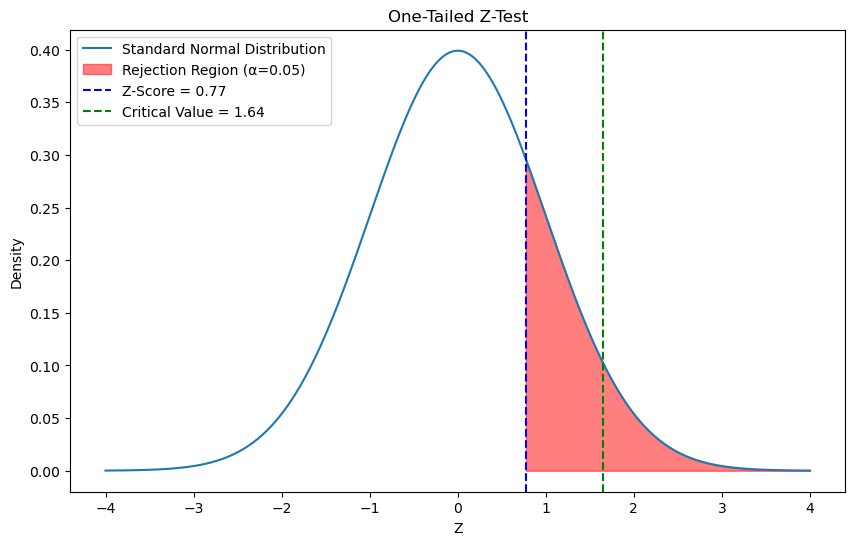

In [5]:

# Hypothesis test: Are premium airlines more punctual than budget airlines
# Combined totals
pooled_p = (budget_ontime + premium_ontime) / (budget_total + premium_total)

# SE
SE = (pooled_p * (1 - pooled_p) * (1 / budget_total + 1 / premium_total)) ** 0.5

# Z-score
z_score = (p_premium - p_budget) / SE

# P-value for a one-tailed test
p_value = 1 - norm.cdf(z_score)

# results
print("Budget Proportion:", p_budget)
print("Premium Proportion:", p_premium)
print("Z-Score: ", z_score)
print("P-Value: ", p_value)

# and final decision
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Premium airlines are  more punctual than budget airlines.")
else:
    print("We fail to reject the null hypothesis: Premium airlines are not more punctual than budget airlines")

# And finally a beautiful graph :)

x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Standard Normal Distribution')
plt.fill_between(x, 0, y, where=(x >= z_score), color='red', alpha=0.5, label='Rejection Region (α=0.05)')
plt.axvline(z_score, color='blue', linestyle='--', label=f'Z-Score = {z_score:.2f}')
plt.axvline(norm.ppf(1 - alpha), color='green', linestyle='--', label=f'Critical Value = {norm.ppf(1 - alpha):.2f}')
plt.legend()
plt.title('One-Tailed Z-Test')
plt.xlabel('Z')
plt.ylabel('Density')
plt.show()

In [6]:
# Let's check other data, starting with time:

filtered_df['Scheduled Time'] = pd.to_datetime(filtered_df['Scheduled Time'], format='%H:%M:%S').dt.time

# Seperating times into seperate 6 hour shifts (morning, afternoon and night)
def categorize_time_of_day(time):
    if time >= pd.to_datetime('06:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('18:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('18:00:00').time() and time < pd.to_datetime('23:59:59').time():
        return 'Evening'
        # weirdly, 00:00:00 doesn't work...
    else:
        return 'Late Night'
    
filtered_df['Time of Day'] = filtered_df['Scheduled Time'].apply(categorize_time_of_day)

filtered_df[['Scheduled Time', 'Time of Day']].sample(20)

,Scheduled Time,Time of Day
1108,11:10:00,Morning
4421,12:00:00,Afternoon
2083,13:55:00,Afternoon
2041,11:05:00,Morning
3412,10:30:00,Morning
1262,21:15:00,Evening
3917,13:15:00,Afternoon
3653,10:35:00,Morning
1278,22:10:00,Evening
3923,13:35:00,Afternoon


In [7]:
# calculate number of morning/afternoon/night flights
time_total_flights = filtered_df['Time of Day'].value_counts()
time_delayed_flights = filtered_df[filtered_df['Status_Delayed'] == 1]['Time of Day'].value_counts()

# figure out the proportion
time_delay_proportion = time_delayed_flights / time_total_flights

# create a new DF
time_delay_df = pd.DataFrame({
    'Total Flights': time_total_flights,
    'Delayed Flights': time_delayed_flights,
    'Delay Chance': time_delay_proportion
}).reset_index().rename(columns={'index': 'Time of Day'})

time_delay_df

,Time of Day,Total Flights,Delayed Flights,Delay Chance
0,Afternoon,1619,927,0.572576
1,Evening,1587,981,0.618147
2,Late Night,7,6,0.857143
3,Morning,1453,445,0.306263


/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


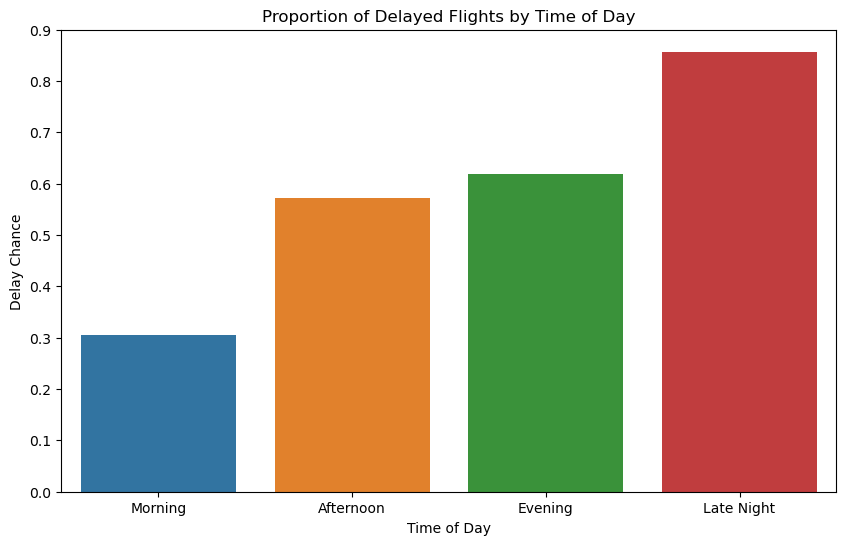

In [8]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

time_order = ['Morning', 'Afternoon', 'Evening', 'Late Night']
# To make sure the order is correct

sns.barplot(x='Time of Day', y='Delay Chance', data=time_delay_df, order=time_order)

plt.xlabel('Time of Day')
plt.ylabel('Delay Chance')
plt.title('Proportion of Delayed Flights by Time of Day')

plt.show()

In [9]:
# Leets check by airline:

airline_total_flights = filtered_df['Airline'].value_counts()
airline_delayed_flights = filtered_df[filtered_df['Status_Delayed'] == 1]['Airline'].value_counts()

# Calculate the proportion
airline_delay_proportion = airline_delayed_flights / airline_total_flights

# creat a new DF
airline_delay_df = pd.DataFrame({
    'Total Flights': airline_total_flights,
    'Delayed Flights': airline_delayed_flights,
    'Delay Chance': airline_delay_proportion
}).reset_index().rename(columns={'index': 'Airline'})

# airline_delay_df

airline_delay_df = airline_delay_df.sort_values(by='Delay Chance', ascending=False)

delay_summary_stats = airline_delay_df['Delay Chance'].describe()

print(delay_summary_stats)

display(airline_delay_df)


count    50.000000
mean      0.440369
std       0.180411
min       0.120000
25%       0.280702
50%       0.461448
75%       0.547813
max       0.833333
Name: Delay Chance, dtype: float64


,Airline,Total Flights,Delayed Flights,Delay Chance
10,Air Serbia (JU),18,15,0.833333
21,Freebird Airlines (FHY),16,13,0.812500
32,Pegasus Airlines (PC),98,75,0.765306
39,Swiss (LX),140,103,0.735714
42,Turkish Airlines (TK),83,56,0.674699
2,(VF),29,19,0.655172
18,Egypt Air (MS),20,13,0.650000
25,KLM Royal Dutch Airlines (KL),125,77,0.616000
3,Aegean Airlines (A3),39,23,0.589744
5,Aero Services Executive (W4),40,23,0.575000


/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


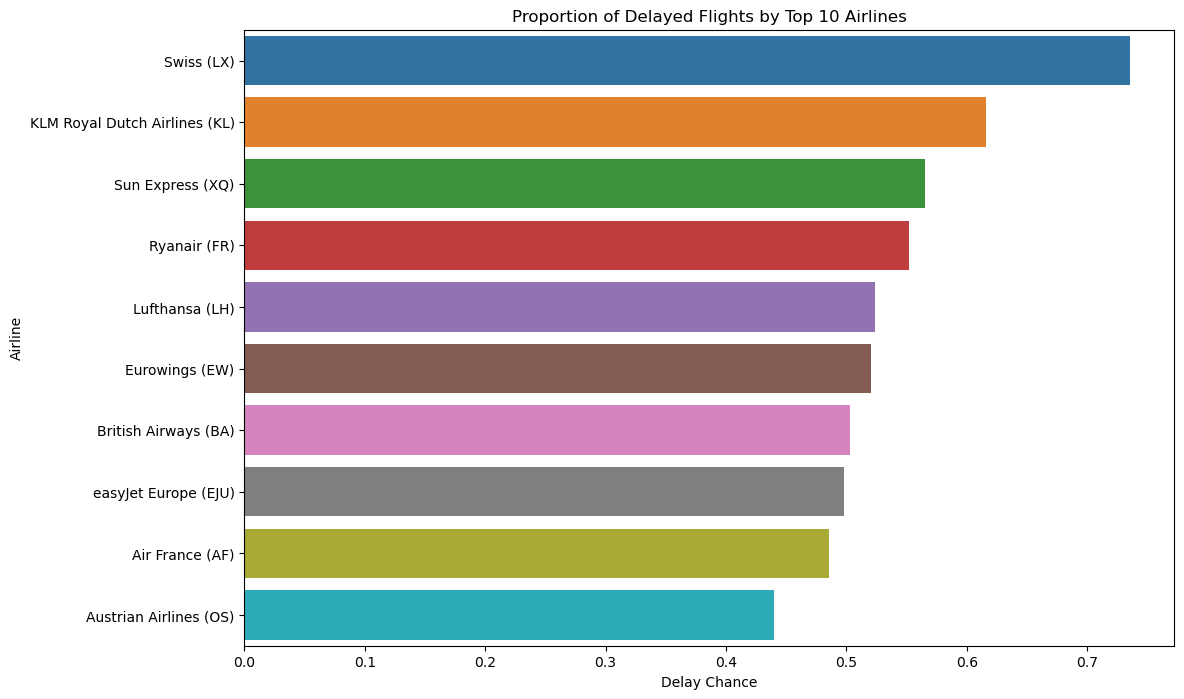

In [10]:
# Let's examine the top10 by number of flights specifically - top10

top_airlines = airline_delay_df.nlargest(10, 'Total Flights')

plt.figure(figsize=(12, 8))

sns.barplot(x='Delay Chance', y='Airline', data=top_airlines.sort_values(by='Delay Chance', ascending=False))

# Add labels and title
plt.xlabel('Delay Chance')
plt.ylabel('Airline')
plt.title('Proportion of Delayed Flights by Top 10 Airlines')

# Show plot
plt.show()

/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


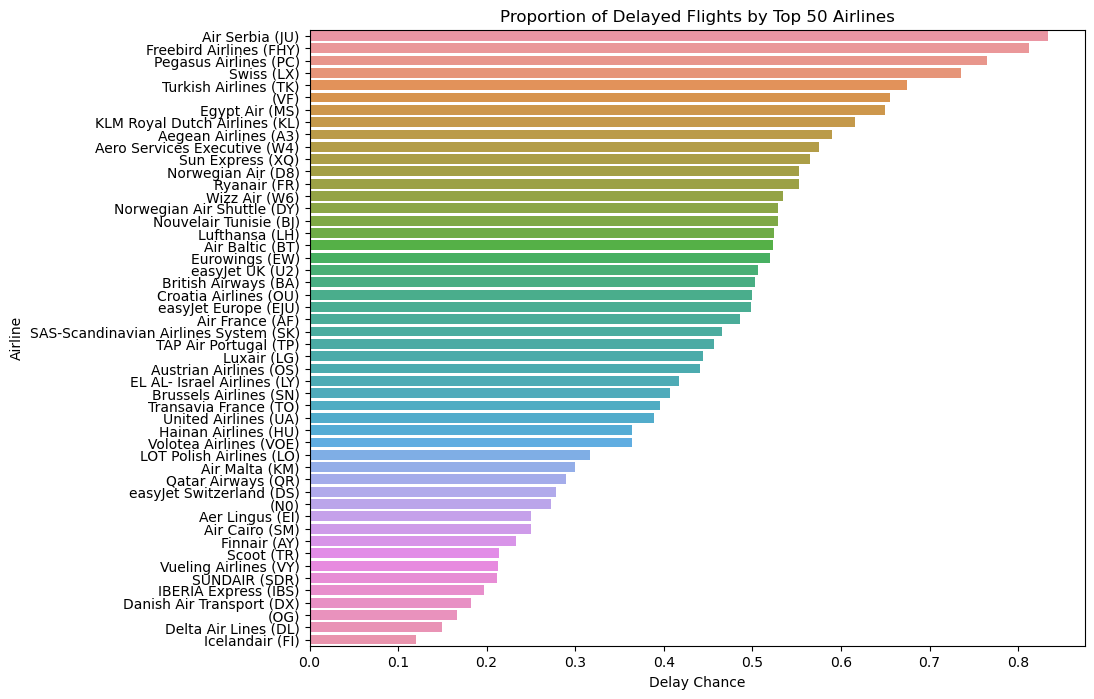

In [11]:
# Let's examine the top10 by number of flights specifically top50

top_airlines_50 = airline_delay_df.nlargest(50, 'Total Flights')

plt.figure(figsize=(10, 8))

sns.barplot(x='Delay Chance', y='Airline', data=top_airlines_50.sort_values(by='Delay Chance', ascending=False))

# Add labels and title
plt.xlabel('Delay Chance')
plt.ylabel('Airline')
plt.title('Proportion of Delayed Flights by Top 50 Airlines')

# Show plot
plt.show()